In [7]:
import math
# import os
# import subprocess
# import sys
import pandas as pd
import numpy as np
from moviepy.editor import AudioClip, VideoFileClip, concatenate_videoclips
# from icecream import ic
import matplotlib.pyplot as plt

#  http://en.kremlin.ru/events/president/news/67828
INPUT_FILE = r'/home/USERNAME/Downloads/Putin.mp4'
OUTPUT_FILE = r'Putin.mp4'
MIN_SECS_OF_APPENDED_CLIPS = 0.4            # in Seconds
THRESHOLD_MAX = 0.009           # Max Volume of Cutted Subclip's Audio (for find_silence_intervals)
THRESHOLD_MIN = 0.35          # Min Volume of Cutted Subclip's Audio (for find_non_silence_intervals)INPUT_FILE = r'/home/USERNAME/Downloads/Putin.mp4'
all_max_volumes = []

In [8]:
def find_silence_intervals(audio_clip, window_size=0.04, threshold=THRESHOLD_MAX):
    # iterate over audio_clip
    num_windows = math.floor(audio_clip.end/window_size)
    silent_windows = []
    silent_big_windows = []
    window_is_silent_LST = []
    for i in range(num_windows):
        s = audio_clip.subclip(i * window_size, (i+1)* window_size)
        v = s.max_volume()

        all_max_volumes.append(v)
        #append silent windows    
        if v < threshold:
            silent_windows.append([round(i*window_size,3),round((i+1)*window_size, 3)])
            if len(silent_windows) > 1:
                ### merge continuous windows
                if silent_windows[-1][0] == silent_windows[-2][1]:
                    ###debug
                    # ic(silent_windows[-1][0], silent_windows[-2][1])
                    silent_windows[-2] = [  silent_windows[-2][0], silent_windows[-1][1]  ]
                    silent_windows = silent_windows[:-1]
    # Keep only Big Windows
    # ic(silent_windows)
    for window in silent_windows:
        start, end = (window[0] , window[1])
        if end - start > MIN_SECS_OF_APPENDED_CLIPS:
            # ic(window)
            silent_big_windows.append(window) 
        
    return silent_big_windows

In [9]:
def find_non_silence_intervals(audio_clip,window_size=0.03, threshold=THRESHOLD_MIN):
    #iterate over audio_clip
    num_windows = math.floor(audio_clip.end/window_size)
    not_silent_windows = []
    non_silent_big_windows = []
    for i in range(num_windows):
        s = audio_clip.subclip(i * window_size, (i+1)* window_size)
        v = s.max_volume()
        if v > threshold:
            not_silent_windows.append([i*window_size, (i+1)*window_size])

    #Keep only Big Windows
    for window in not_silent_windows:
        start, end = (window[0] , window[1])
        if end - start > MIN_SECS_OF_APPENDED_CLIPS:
            # ic(window)
            non_silent_big_windows.append(window) 
        
    return not_silent_windows

In [10]:
def main():
    vid = VideoFileClip(INPUT_FILE)
    intervals_to_keep = find_silence_intervals(vid.audio)
    
    subvids_to_keep = [vid.subclip(start, end) for [start, end] in intervals_to_keep]

    edited_video = concatenate_videoclips(subvids_to_keep, method='compose', padding= -0.2)
    edited_video.write_videofile(OUTPUT_FILE,
        fps=30,
        preset='ultrafast',
        codec='libx264',
        temp_audiofile='temp-audio.m4a',
        remove_temp=True,
        audio_codec='aac',
        threads=6
        )
    
    vid.close()

if __name__ == "__main__":
    main()

chunk:   0%|          | 0/486 [00:00<?, ?it/s, now=None]

Moviepy - Building video Putin.mp4.
MoviePy - Writing audio in temp-audio.m4a


t:   0%|          | 2/655 [00:00<00:52, 12.37it/s, now=None]      

MoviePy - Done.
Moviepy - Writing video Putin.mp4



Moviepy - Done !
Moviepy - video ready Putin.mp4


## Histogram Of Max_Volumes Of SubClips

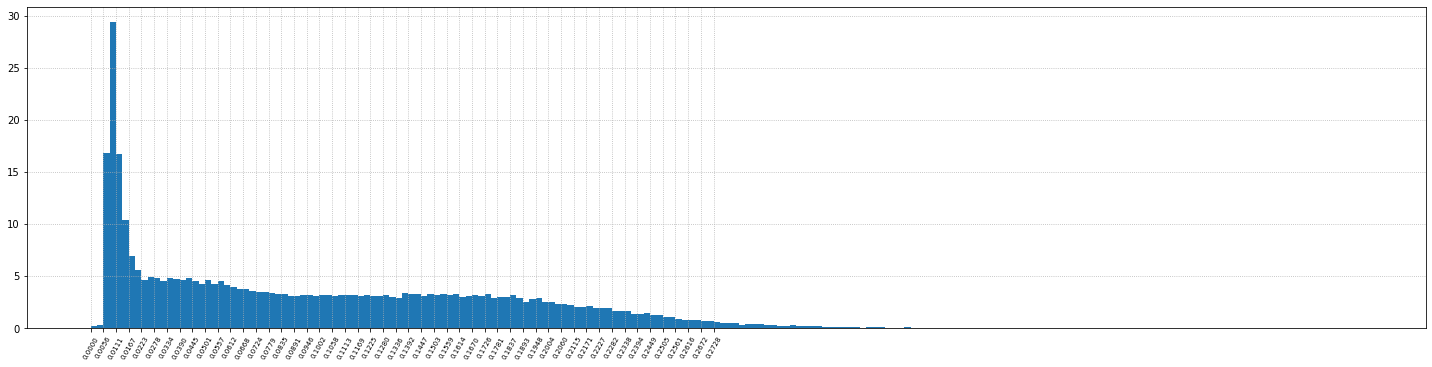

In [11]:
max_series = pd.Series(all_max_volumes)

fig, ax = plt.subplots(figsize= (20, 5))
n, bins, patches = ax.hist(max_series, 200, density=True)
fig.tight_layout()
plt.xticks(np.arange(0, max(max_series)/2, max(max_series)/200*2), rotation= 60, fontsize=7)

ax.grid(True, linestyle='dotted')
plt.show()



## Normalize Audio Of OUTPUT_FILE

In [12]:
### Normalize Audio Of OUTPUT_FILE
# %%bash
! ffmpeg-normalize $OUTPUT_FILE -vf -t -35

INFO: Normalizing file Putin.mp4 (1 of 1)
INFO: Running first pass loudnorm filter for stream 1
INFO: Running second pass for Putin.mp4
INFO: Normalized file written to normalized/Putin.mkv
